# Bitdefender Premium VPN
## Voice-Of-Customer Research & Analysis

In [50]:
%matplotlib inline
#%matplotlib notebook

# generic packages
import sys
import re, numpy as np, pandas as pd
from pprint import pprint
from matplotlib.ticker import PercentFormatter

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 1)

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


# graphing, vis stuff
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models

# gensim for topic modelling
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# additional libraries
from collections import Counter


# add custom definitions here

def prettify(df): # make tables pretty and easier to scan
    cell_hover = {
        'selector': 'td:hover',
        'props': [('background-color', '#ffffb3')]
    }
    
    headers = {
        'selector': 'th:not(.index_name)',
        'props': 'text-align: left; font-size: 1.8rem; font-family: Helvetica;'
    }
    cells = {
        'selector': 'td',
        'props': 'text-align: left; font-size: 1.4rem; padding:10px 30px 10px 10px;'
    }
    return df.style.set_table_styles([cell_hover, headers, cells]).hide_index()


# initial parsing of a single or multi option question ...
def process_cat_question(df, col_idx, open_sep, multi_sep = " | "): 

    # step 1: split & melt a survey question by multi-cat first
    melted_df = (df.iloc[:, col_idx]
          .str.replace(multi_sep, '%%', regex=False)
          .str.split('%%', expand=True)
          .melt()
          .drop("variable", axis=1))

    # step 2: split survey question by open separator
    cat_and_open = (melted_df.iloc[:, 0]
                    .str.replace(open_sep, '%%', regex=False)
                    .str.split('%%', expand=True))

    # step 3: summarize category options
    cat_summary = (pd.DataFrame(cat_and_open.groupby(0).size())
                           .rename(columns={0:'Count'})
                           .sort_values("Count", ascending=False)
                           .reset_index())
    cat_total = cat_summary['Count'].sum()
    cat_summary["% of Sample"] = cat_summary['Count'].apply(lambda x: x/cat_total*100)
    cat_summary = cat_summary.rename(columns={0:"Category"})
    
    return cat_and_open, cat_summary


def count_category(df, colname):
    cat_summary = (pd.DataFrame(df.groupby(colname).size())
                           .rename(columns={0:'Count'})
                           .sort_values("Count", ascending=False)
                           .reset_index())
    cat_total = cat_summary['Count'].sum()
    cat_summary["% of Sample"] = cat_summary['Count'].apply(lambda x: x/cat_total*100)
    cat_summary = cat_summary.rename(columns={0:"Category"})
    return(cat_summary)


def c_to_df(counter):
        df = (pd.DataFrame.from_dict(counter, orient='index')
              .reset_index()
              .sort_values(0, ascending=False)
              .dropna())
        return(df)

    
def add_value_labels(ax, spacing=5):

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}%".format(y_value*100)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

def summarize_lda_q(csv_name): 
    
    input_csv = csv_name
    lda_result_df = pd.read_csv(input_csv).iloc[: , 1:] # drop first column
    topic_summary = pd.pivot_table(lda_result_df, values=['Topic_Perc_Contrib', 'Dominant_Topic'], index=['Keywords'],
                    aggfunc={'Dominant_Topic': np.size})

    topic_summary =  topic_summary.rename(columns = {
        'Topic Keywords' : 'Top_Theme_Keywords',
        'Dominant_Topic': 'Count'}).sort_values(by='Count', ascending=False).reset_index()
    
    topic_cols = np.arange(1, len(topic_summary)+1, 1)
    topic_summary["Dominant Topic No."] = topic_cols
    column_names = ["Dominant Topic No.", "Keywords", "Count"]
    topic_summary = topic_summary.reindex(columns=column_names)
    
    return topic_summary


def get_top10_verbatims(csv_name, topic_summary):
    input_csv = csv_name
    lda_result_df = pd.read_csv(input_csv).iloc[: , 1:] # drop first column
     
    topic_verbatims = [pd.DataFrame(lda_result_df[lda_result_df["Keywords"] == topic_summary.iloc[x,1]].iloc[:,5].head(20)) for x in range(len(topic_summary))]
    
    return topic_verbatims 


In [51]:
# load and filter data for analysis ...

raw_csv = pd.read_csv("bitdefender_vpn_customer_responses.csv")

cols_to_keep = ['How did you first hear about Bitdefender Premium VPN ?',
                'Which, if any, alternatives did you consider before deciding on Bitdefender Premium VPN?',
                'What 3 adjectives would you use to describe Bitdefender Premium VPN?',
                'On a scale of 0 to 10, how happy are you with Bitdefender Premium VPN? ',
                'Do you currently use any OTHER Bitdefender products or plans (e.g. security/antivirus, identity protection, etc.)?']

all_users = raw_csv[cols_to_keep]

# How Do Users First Hear About The Product?

In [52]:
q1_cat_and_open, q1_cat_summary = process_cat_question(df = all_users,
                                                       col_idx = 0,
                                                       open_sep = "(click here to type) -")
# edit the table copy to make more readable
q1_cat_summary.at[0, "Category"] = "Received email"
q1_cat_summary.at[2, "Category"] = "Googled / searched"
q1_cat_summary.at[3, "Category"] = "Clicked an ad"
q1_cat_summary.at[5, "Category"] = "Read about it online"

# merge 'read about it on ...' and 'heard suggested in comment on ...' totals
total = q1_cat_summary.iloc[5:7]["Count"].sum() 
q1_cat_summary.at[5, "Count"] = total
q1_cat_summary = q1_cat_summary.drop(index=6).rename(columns = {'Category':'How did you first hear about Bitdefender Premium VPN?'})

prettify(q1_cat_summary)

How did you first hear about Bitdefender Premium VPN?,Count,% of Sample
Received email,1085,26.5
Other,1015,24.8
Googled / searched,622,15.2
Clicked an ad,481,11.8
A friend told me about it,456,11.2
Read about it online,429,9.2


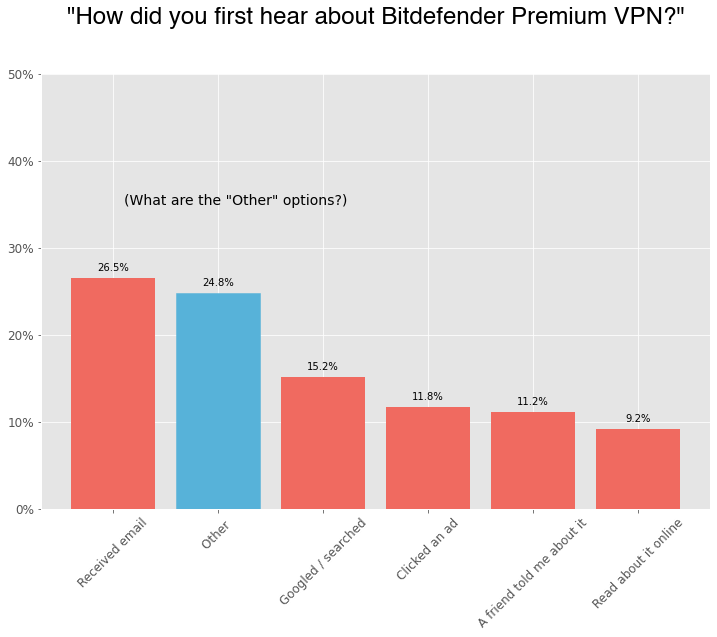

In [53]:
q1_vals = q1_cat_summary.iloc[:,0]
q1_heights = q1_cat_summary.iloc[:,2]/100

plt.figure(figsize=(12,8))
plt.style.use('ggplot')
barlist = plt.bar(q1_vals, q1_heights, color="#F06A60")
barlist[1].set_color('#57B2D9')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.title('"How did you first hear about Bitdefender Premium VPN?"', color="#000", fontsize=24,  pad=50, fontname="Helvetica", fontweight="bold")

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Increase size of axis tick values
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.ylim([0, 0.5])
add_value_labels(plt.gca(), spacing=5)
plt.annotate('(What are the "Other" options?)', xy =(0.1, 0.35), fontsize=14)
plt.show() 

In [54]:
# what do people say with 'other'?
q1_other = q1_cat_and_open[q1_cat_and_open.iloc[:,0] == "Other "]
q1_other.to_csv("q1_other_texts.csv")

# Run LDA analysis and then clean up in Google Docs w/ VOC Analysis Kit ...
q1_other_cleaned = pd.read_csv("q1_other_cleaned.csv") # load human-cleaned version
    
q1_other_count = count_category(q1_other_cleaned, "Category").rename(columns={'Category':'"Other" Responses'})
prettify(q1_other_count.head(10))

"""Other"" Responses",Count,% of Sample
already had BD product,314,56.9
recommended by pro,77,13.9
researched security software,38,6.9
don't remember,37,6.7
got BD offer email,13,2.4
family,12,2.2
Bitdefender website,10,1.8
came with Netgear,8,1.4
didn't know I have it,6,1.1
consumer reports,5,0.9


### Key Findings


- Over 25% of Bitdefender VPN users say they first heard about the service from a Bitdefender email, implying that they were already subscribed to another Bitdefender product (likely antivirus-related)


- Another 25% of BD VPN users selected 'Other' as a response


- Nearly 60% of those who chose 'Other' say they already had another BD product and learned about the VPN either through promotional emails, upsells in checkout flow of their first product, or in-app promotions


- Combining the above, we can estimate that 40% of BD VPN users hear about it as a result of being a pre-existing Bitdefender security/antivirus customer


<h1>What Other BD Products Do Users Use?</h1>


In [55]:
other_bd_cat_and_open, other_bd_cat_summary = process_cat_question(df = all_users,
                                                       col_idx = 4,
                                                       open_sep = "(click here to type) -")

other_bd_cat_summary = other_bd_cat_summary.rename(columns = {"Category" : "Do you currently use any OTHER Bitdefender products or plans?"})



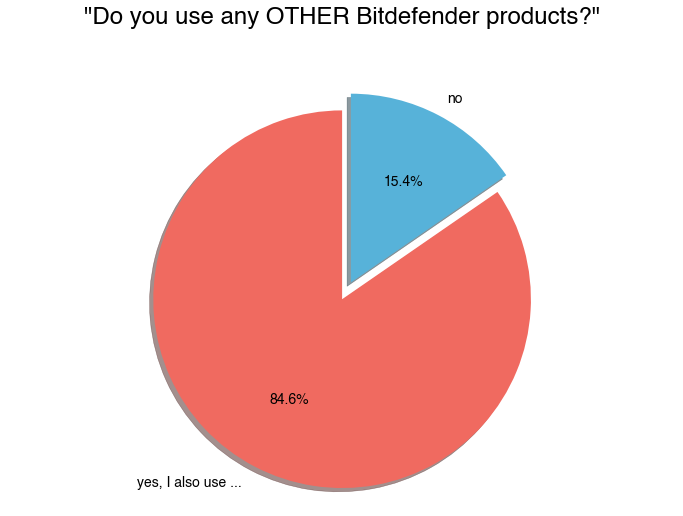

In [56]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:


labels = other_bd_cat_summary.iloc[:,0]
sizes = other_bd_cat_summary.iloc[:,2]
colors = ['#F06A60','#57B2D9']

explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(12,8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', colors=colors, 
        shadow=True, startangle=90, textprops={'fontsize': 14, 'fontname': 'Helvetica'})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('"Do you use any OTHER Bitdefender products?"', color="#000", fontsize=24,  pad=50, fontname="Helvetica", fontweight="bold")


plt.show()

In [57]:
# what do people say with 'other'?
other_bd_open= other_bd_cat_and_open.iloc[:,1]
other_bd_open.to_csv("other_bd_open.csv")

# Run LDA analysis and then clean up in Google Docs w/ VOC Analysis Kit ...
other_bd_cleaned = (pd.read_csv("other_bd_cleaned.csv")
                  .rename(columns={'BD Product':'"Yes, I also use ..."'})) # load human-cleaned version
    
prettify(other_bd_cleaned)

"""Yes, I also use ...""",Estimated Count
"""security"" and/or ""antivirus""",1465
total (security),751
identity protection,124
internet (security),123
family,30
box,29
mobile,28
for mac,26
premium,21


### Key Findings


- A full 85% of respondents to this question (approximately 65% of total survey sample) say they also use another Bitdefender product. 


- Unfortunately, the homogeneity of BD product names (e.g. multiple products with shared terms such as like 'security' and 'antivirus') combined with the large sample size and open-text question format made it difficult to measure the exact distribution of BD products among VPN users. 


- Using simple bag-of-words NLP processing, we were able to get a rough estimate of the product use distribution among VPN users as shown above: a large proportion of users simply wrote 'security' or 'antivirus' (or both). The main takeaway we can glean from this estimate is the relative dominance of Bitdefender antivirus products (most likely Total Security).


- **FOR NEXT TIME**: Any questions about Bitdefender products should be formatted as a multi-choice checkbox question. 

# What Competitors Do Users Consider Most?

In [58]:
q2_cat_and_open, q2_cat_summary = process_cat_question(df = all_users,
                                                       col_idx = 1,
                                                       open_sep = "(click here to tyoe) -")

q2_cat_summary = q2_cat_summary.rename(columns={"Category":"Which other alternative(s) did you consider before deciding on Bitdefender Premium VPN?"})

q2_cat_summary.at[0, "Which other alternative(s) did you consider before deciding on Bitdefender Premium VPN?"] = "None"

prettify(q2_cat_summary)

Which other alternative(s) did you consider before deciding on Bitdefender Premium VPN?,Count,% of Sample
None,2055,52.9
Nord VPN,713,18.4
Other,584,15.0
Express VPN,421,10.8
Cyberghost VPN,110,2.8


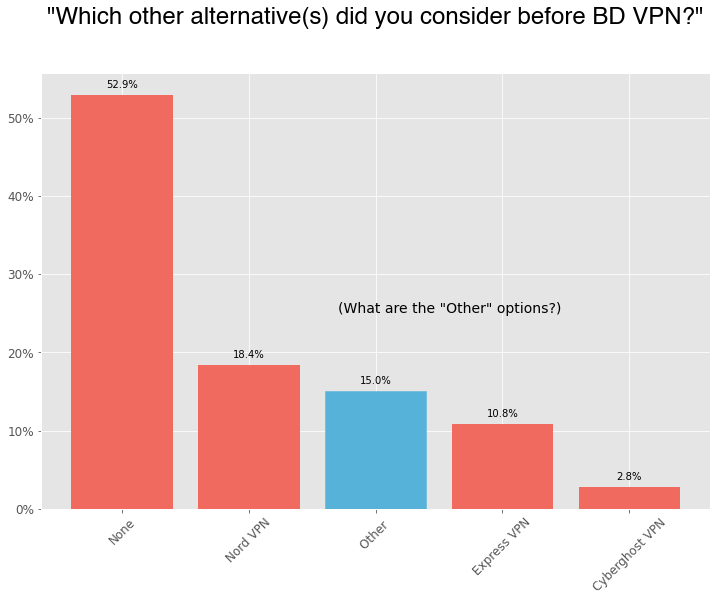

In [59]:
x_vals = q2_cat_summary.iloc[:,0]
heights = q2_cat_summary.iloc[:,2]/100


plt.figure(figsize=(12,8))
plt.style.use('ggplot')
barlist = plt.bar(x_vals, heights, color="#F06A60")
barlist[2].set_color('#57B2D9')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.title('"Which other alternative(s) did you consider before BD VPN?"', color="#000", fontsize=24,  pad=50, fontname="Helvetica", fontweight="bold")

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Increase size of axis tick values
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

add_value_labels(plt.gca(), spacing=5)
plt.annotate('(What are the "Other" options?)', xy =(1.7, 0.25), fontsize=14)

plt.show() 

In [60]:
# what do people say with 'other'?
q2_other = q2_cat_and_open.iloc[:,1]
q2_other.to_csv("q2_other_texts.csv")

# Run LDA analysis and then clean up in Google Docs w/ VOC Analysis Kit ...
q2_other_cleaned = (pd.read_csv("competitors_cleaned.csv")
                    .rename(columns={'Competitor':'Top 10 "Other" Mentions'})) # load human-cleaned version
    
prettify(q2_other_cleaned)

"Top 10 ""Other"" Mentions",Count
norton,79
pia,31
mozilla,31
avast,29
mcafee,24
avg,22
proton,20
kaspersky,17
surfshark,15
ipvanish,9


#### Key Findings

- More than half of BD VPN customers didn't comparison-shop against other VPNs, they simply chose Bitdefender as their first choice. 


- 15% of BD VPN customers chose 'Other', implying they considered other options. The range of VPNs listed under 'Other' was quite varied; no specific competitor within this group stood out as a conspicuous contender, relative to those listed in the original survey question.


- The most common competitor selected by users who did consider another VPN was NordVPN, followed by ExpressVPN. 


- **MESSAGING OPPORTUNITY:** Virtually ALL the top VPN competitors mentioned by customers charge nearly 2X as much per year (regular price USD 99/year) than Bitdefender VPN (USD 49/year). However, none of Bitdefender VPN's marketing or sales messaging highlights this unique value. 


# How Happy Are Users With The Product?

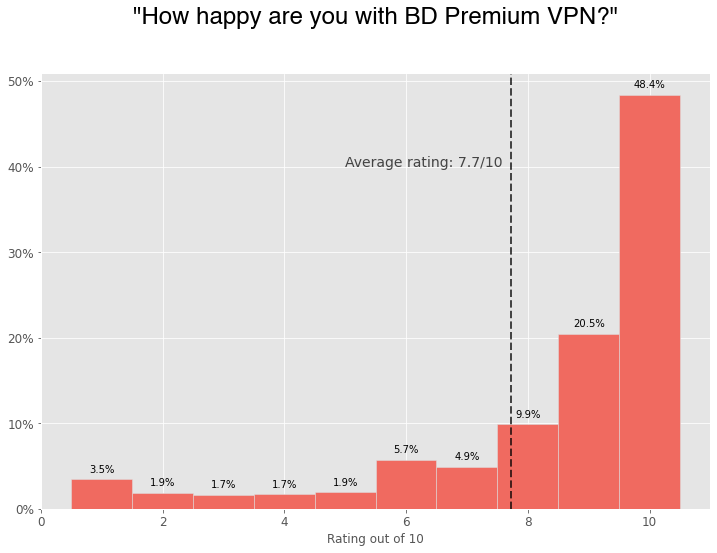

In [61]:
ratings = all_users.iloc[:,3]
chart_mean = np.mean(ratings)
mean_label = "Average rating: {:.1f}/10".format(chart_mean)

plt.figure(figsize=(12,8))
plt.style.use('ggplot')

plt.hist(ratings, density=True, align = 'right', edgecolor='#e0e0e0',color="#F06A60", linewidth=0.5, bins=10)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.title('"How happy are you with BD Premium VPN?"', color="#000", fontsize=24,  pad=50, fontname="Helvetica", fontweight="bold")

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Increase size of axis tick values
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

add_value_labels(plt.gca(), spacing=5)

plt.axvline(chart_mean, color='k', linestyle='dashed',alpha=0.7, linewidth=2)
plt.gca().text(x=5, y=0.4, s=mean_label, color='k', alpha=0.7, fontsize=14)
plt.xlabel('Rating out of 10')
plt.show() 

# How do happy users *perceive* the product?

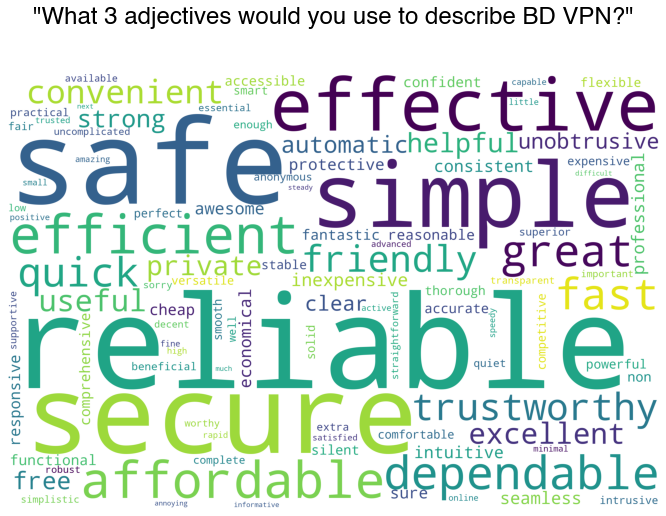

In [62]:
adjectives_df = pd.read_csv("cleaned_adjectives.csv").drop("Unnamed: 0", axis=1)
words = adjectives_df.iloc[:,0]
freq = adjectives_df.iloc[:,1]
word_cloud_dict = dict(zip(words, freq))


from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white',width=3000,
                      height=2000,
                      max_words=100,
                      normalize_plurals=False).generate_from_frequencies(word_cloud_dict)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('"What 3 adjectives would you use to describe BD VPN?"', color="#000", fontsize=24,  pad=50, fontname="Helvetica", fontweight="bold")
plt.show()

In [81]:
adjectives_df = adjectives_df.rename(columns={'Adjective':'Adjective     '})

prettify(adjectives_df.head(10))

Adjective,Mentions
reliable,294
safe,239
secure,207
simple,134
effective,132
efficient,64
affordable,57
dependable,56
great,52
fast,49


#### Key Findings

- Among users who rated the product 9 or 10 (out of 10), the most common adjectives used to describe the product were words like "reliable," "safe,", "secure," "simple," and "effective." However, these descriptors are not currently being used anywhere in existing upsell or cross-selling sales copy for the product.  


- **MESSAGING OPPORTUNITY:** Use these terms in headlines and subheadlines to describe the premium VPN experience. 


# What triggers VPN users to purchase?

In [64]:
purchase_prompt_themes = summarize_lda_q("purchase_prompt_lda_analysis.csv")
prettify(purchase_prompt_themes)

Dominant Topic No.,Keywords,Count
1,"vpn, bitdefender, product, price, work, year, service, already, keep, safe",1083
2,"security, internet, safety, add, additional, track, browse, home, provide, surf",352
3,"computer, protect, email, access, information, site, datum, able, personal, country",224
4,"protection, well, travel, idea, extra, layer, hotel, home, virus, reputation",143
5,"privacy, issue, world, notice, comment, aspect, bit_defender, home, invasion, cybersecurity",119
6,"secure, concern, increase, cyber, connection, breach, option, threat, transaction, crime",72
7,"online, banking, much, thing, shopping, vpns, transaction, procurement, action, activity",70
8,"scam, hacker, website, bad, number, net, surf, avoid, theft, prevent",50


In [65]:
purchase_prompt_verbatims = get_top10_verbatims("purchase_prompt_lda_analysis.csv", purchase_prompt_themes)


In [66]:
topic_idx = 3
question_type = "Purchase Prompt Topic #"
topic_no = str(purchase_prompt_themes.iloc[topic_idx,0])


verbatim_header = question_type + topic_no + ': Verbatims'
verbatim_table = purchase_prompt_verbatims[topic_idx].rename(columns={'content': verbatim_header})


prettify(verbatim_table)

Purchase Prompt Topic #4: Verbatims
seemed like a good idea for better protection
It seemed like a good idea for extra protection.
"I have always been conscious of cybersecurity (More than the average person) So when they recommended this extra addition, it was a natural next step. (By the way, they made a comment during the podcast (Free wifi isn't your friend). I sometimes travel away from home and need to use free wifi."
i NEEDED PROTECTION AND WANTED TO FIND SOMETHING THAT WAS BETTER AND CHEAPER THEN HE REST. i FOUND IT . YOU !!!
I am starting an eCommerce business and thought the extra protection made sense
"My wife and I were traveling. Since we would be using hotel wifi systems and other public systems, I wanted the protection."
Protection using WiFi networks while travelling.
something that I thought I should do for better protection
wanted extra protection.
"I wanted to get some extra protection, especially when I on public WiFi areas"


In [67]:
topic_idx = 4
question_type = "Purchase Prompt Topic #"
topic_no = str(purchase_prompt_themes.iloc[topic_idx,0])


verbatim_header = question_type + topic_no + ': Verbatims'
verbatim_table = purchase_prompt_verbatims[topic_idx].rename(columns={'content': verbatim_header})


prettify(verbatim_table)

Purchase Prompt Topic #5: Verbatims
Privacy issues.
Privacy. Privacy is a very important issue to me.
Heightened sense of invasion of privacy from rise in tailored spam adverts.
"The need for privacy. However, my life circumstances have changed substantially, and I may not require it in the same way in the future."
I need a US one in order to watch some TV and movie trailers. I also use it for privacy.
Identity Fraud prevention and private viewing.... privacy.
Due to the ability to get connected any where around the world.
Privacy and the ability to get different Netflix content from other regions.
I tend to be a lot of places with open WiFi and want to ensure privacy.
"Troublesome news reports about invasion of privacy, tracking, etc."


# Why do users ultimately choose BD over other options?

In [82]:
comp_edge_themes = summarize_lda_q("comp_edge_lda_analysis.csv")
prettify(comp_edge_themes)

Dominant Topic No.,Keywords,Count
1,"bitdefender, already, price, product, vpn, antivirus, offer, computer, trust, year",1185
2,"review, work, protection, virus, friend, user, recommendation, anti, service, base",292
3,"security, total, software, reputation, rating, like, experience, internet, decide, bundle",244
4,"well, package, bit_defender, feel, recommend, time, great, deal, web, value",194
5,"part, subscription, integrate, tech, online, issue, state, together, program, available",75


In [69]:
comp_edge_verbatims = get_top10_verbatims("comp_edge_lda_analysis.csv", comp_edge_themes)


In [86]:
topic_idx = 4
question_type = "Competitive Edge "
topic_no = str(comp_edge_themes.iloc[topic_idx,0])
topic_desc = " (brand trust + good price/offer)"

verbatim_header = question_type + topic_no + ' Verbatims' + topic_desc
verbatim_table = comp_edge_verbatims[topic_idx].rename(columns={'content': verbatim_header})


prettify(verbatim_table)

Competitive Edge 5 Verbatims (brand trust + good price/offer)
"Met my needs, easy of operation and it reacts to online threats."
As previously stated
Was part of my subscription.
It was part of bitfender
as previously stated
I have the main program
Previously stated.
"convenience, built in"
Same as previously mentioned
Multiple platforms



# What pain(s) are users trying to eliminate with BD VPN?

In [105]:
top_pain_themes = summarize_lda_q("top_pain_lda_analysis.csv")
prettify(top_pain_themes)

Dominant Topic No.,Keywords,Count
1,"none, security, vpn, internet, work, safe, site, feel, website, access",1238
2,"worry, keep, privacy, hack, hacker, track, private, concern, virus, transaction",443
3,"online, mind, problem, peace, thing, bitdefender, add, bank, specific, watch",405
4,"secure, slow, connection, network, public, computer, less, sure, search, spam",238


In [72]:
top_pain_verbatims = get_top10_verbatims("top_pain_lda_analysis.csv", top_pain_themes)

In [108]:
topic_idx = 3
question_type = "Top Pain "
topic_no = str(top_pain_themes.iloc[topic_idx,0])

verbatim_header = question_type + topic_no + ' Verbatims'
verbatim_table = top_pain_verbatims[topic_idx].rename(columns={'content': verbatim_header})


prettify(verbatim_table)

Top Pain 4 Verbatims
Seem to be getting less spam (junk) mail
Less bugs slowing performance of computer
the stress knowing my searches are secure.
Don't receive as many spam messages.
slow server selection and connection
less junk mail
the speed is way too slow - I probably will not renew
Slowing down the advertising directed by my search patterns.
I purchased it so that I could use my laptop more safely in areas with public wi-fi.
Being vulnerable in public wifi areas.


In [74]:
topic_idx = 1
question_type = "Top Pain "
topic_no = str(top_pain_themes.iloc[topic_idx,0])
topic_desc = " (fear of getting hacked, theft, spying)"

verbatim_header = question_type + topic_no + ' Verbatims' + topic_desc
verbatim_table = top_pain_verbatims[topic_idx].rename(columns={'content': verbatim_header})


prettify(verbatim_table)

"Top Pain 2 Verbatims (fear of getting hacked, theft, spying)"
"threat of identity theft, ransomeware, stolen data, financial crimes, etc."
Tracking and collection of personal data and information
The worry of 'hacking' and 'tracking' by harmful people.
The possibility of being hacked by others and my identity and information being stolen.
People trying to steal personal info
Concerns of hacking my personal information.
Concern about financial data being stolen
"Concern of being tracked, info stolen"
Lessened worries when making financial transactions.
worries over my personal info and browsing.


In [75]:
topic_idx = 2
question_type = "Top Pain "
topic_no = str(top_pain_themes.iloc[topic_idx,0])
topic_desc = " (peace of mind, added security)"

verbatim_header = question_type + topic_no + ' Verbatims' + topic_desc
verbatim_table = top_pain_verbatims[topic_idx].rename(columns={'content': verbatim_header})


prettify(verbatim_table)

"Top Pain 3 Verbatims (peace of mind, added security)"
"actually, it's added a problem as it often disconnects so I have to reconnect."
"Its given me peace of mind, i was using Avast prior to BitDefender"
It's actually caused some problems. I don't know if it has mitigated any problems.
It has just given us a bit more peace of mind.
No pain or problem was eliminated at this time.
I can't give you a specific problem but more importantly for me it has given me piece of mind that I am protected. Mind you I don't put myself into shady websites.
"Hard to say, it has created several new ones."
"Installation was a bit of a pain, but that was mostly because McAfee was so hard to remove."
Added safety and awareness of another layer of protection.
"I'm still new to all this, yet to determine"


In [87]:
top_benefit_themes = summarize_lda_q("top_benefit_lda_analysis.csv")
prettify(top_benefit_themes)

Dominant Topic No.,Keywords,Count
1,"privacy, online, security, anonymity, increase, tranzactiile, personal, safe, time, set",296
2,"mind, peace, real, imagine, give, reputable, company, piece, state, check",295
3,"feel, secure, safe, web, connection, internet, security, browsing, npm, economical",245
4,"really, benefit, cancel, sub, much, none, tell, receive, sure, imagine",71
5,"watch, able, service, streaming, abroad, match, country, football, supposedly, foreign",16


In [88]:
top_benefit_verbatims = get_top10_verbatims("top_benefit_lda_analysis.csv", top_benefit_themes)

In [104]:
topic_idx = 2
question_type = "Top Benefit "
topic_no = str(top_benefit_themes.iloc[topic_idx,0])

verbatim_header = question_type + topic_no + ' Verbatims'
verbatim_table = top_benefit_verbatims[topic_idx].rename(columns={'content': verbatim_header})


prettify(verbatim_table)

Top Benefit 3 Verbatims
Feeling more secure
Feel more secure on public wifi
feel protected and secure
feel more secure
feeling more secure
Feel me secure in my everyday use of my computer
feel more secure
feeling more secure
Feeling more secure
I feel more secure


# Top Messaging/Copy Opportunities for Premium VPN ...